In [4]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import pandas as pd
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy import stats

In [5]:
# Load the California Housing dataset
housing = fetch_california_housing(as_frame=True)


df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
df["target"] = housing.target

df = df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]
df = df.reset_index(drop=True)
X = df[housing.feature_names]
targets = df["target"]
# Always use transform_data function on X
scaler = StandardScaler().fit(np.array(targets).reshape(-1, 1))
targets = scaler.transform(np.array(targets).reshape(-1, 1)).flatten()

df["target"] = targets
data=df

In [6]:
import sys
sys.path.append('..')
from nampy.models.NAMLSS import NAMLSS

In [7]:
namlss = NAMLSS(
    "target ~  -1 + MLP(MedInc) + MLP(AveOccup) + MLP(AveBedrms) + MLP(Population)+  MLP(Latitude; encoding=one_hot; n_bins=50; hidden_dims=[12, 12, 12]) + MLP(Longitude):MLP(AveRooms)", 
    data=data, 
    family="Normal", 
    feature_dropout=0.0001,
    loss="nll"
    )


--- Preprocessing ---


0it [00:00, ?it/s]

8it [00:03,  2.43it/s]
7it [00:00, 869.29it/s]


In [8]:
def KL_Divergence(y_true, y_hat):
    t = tfd.Normal(loc=y_true, scale=tf.math.reduce_std(y_true))
    p = tfd.Normal(loc=y_hat, scale=tf.math.reduce_std(y_true))  
    kl = tf.reduce_mean(tfd.kl_divergence(t, p, allow_nan_stats=True))
    return kl

namlss.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss={"output":namlss.Loss}, 
    metrics={"output": KL_Divergence, "summed_output":"mse"}
    )

# Train the model
namlss.fit(namlss.training_dataset, epochs=150, validation_data=namlss.validation_dataset)

# Evaluate the model
loss = namlss.evaluate(namlss.validation_dataset)
print("Test Loss:", loss)

Epoch 1/150
------------- Network architecture --------------
MedInc -> MLP(feature=MedInc, n_params=12800) -> output dimension=2
AveOccup -> MLP(feature=AveOccup, n_params=12800) -> output dimension=2
AveBedrms -> MLP(feature=AveBedrms, n_params=12800) -> output dimension=2
Population -> MLP(feature=Population, n_params=12800) -> output dimension=2
Latitude -> MLP(feature=Latitude, n_params=948) -> output dimension=2
Longitude_._AveRooms -> MLP(feature=Longitude_._AveRooms, n_params=12928) -> output dimension=2


c:\Users\anton\anaconda3\envs\xDL_venv\lib\site-packages\keras\src\engine\functional.py:642: UserWarning: Input dict contained keys ['AveOccup', 'AveBedrms', 'Population', 'Latitude', 'Longitude_.', 'AveRooms_.'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
c:\Users\anton\anaconda3\envs\xDL_venv\lib\site-packages\keras\src\engine\functional.py:642: UserWarning: Input dict contained keys ['MedInc', 'AveBedrms', 'Population', 'Latitude', 'Longitude_.', 'AveRooms_.'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
c:\Users\anton\anaconda3\envs\xDL_venv\lib\site-packages\keras\src\engine\functional.py:642: UserWarning: Input dict contained keys ['MedInc', 'AveOccup', 'Population', 'Latitude', 'Longitude_.', 'AveRooms_.'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs

16/16 [==============================] - 4s 39ms/step - loss: 1.5665 - output_loss: 1.5665 - output_KL_Divergence: 1.4020 - summed_output_mse: 1.5004 - val_loss: 1.3132 - val_output_loss: 1.3132 - val_output_KL_Divergence: 1.0943 - val_summed_output_mse: 1.1459
Epoch 2/150
16/16 [==============================] - 0s 22ms/step - loss: 1.3313 - output_loss: 1.3313 - output_KL_Divergence: 1.0558 - summed_output_mse: 1.1481 - val_loss: 1.0995 - val_output_loss: 1.0995 - val_output_KL_Divergence: 0.6328 - val_summed_output_mse: 0.7379
Epoch 3/150
16/16 [==============================] - 0s 23ms/step - loss: 1.9547 - output_loss: 1.9547 - output_KL_Divergence: 0.7841 - summed_output_mse: 0.8706 - val_loss: 1.0705 - val_output_loss: 1.0705 - val_output_KL_Divergence: 0.6671 - val_summed_output_mse: 0.7157
Epoch 4/150
16/16 [==============================] - 1s 32ms/step - loss: 1.1755 - output_loss: 1.1755 - output_KL_Divergence: 0.7612 - summed_output_mse: 0.8056 - val_loss: 1.0231 - val_out

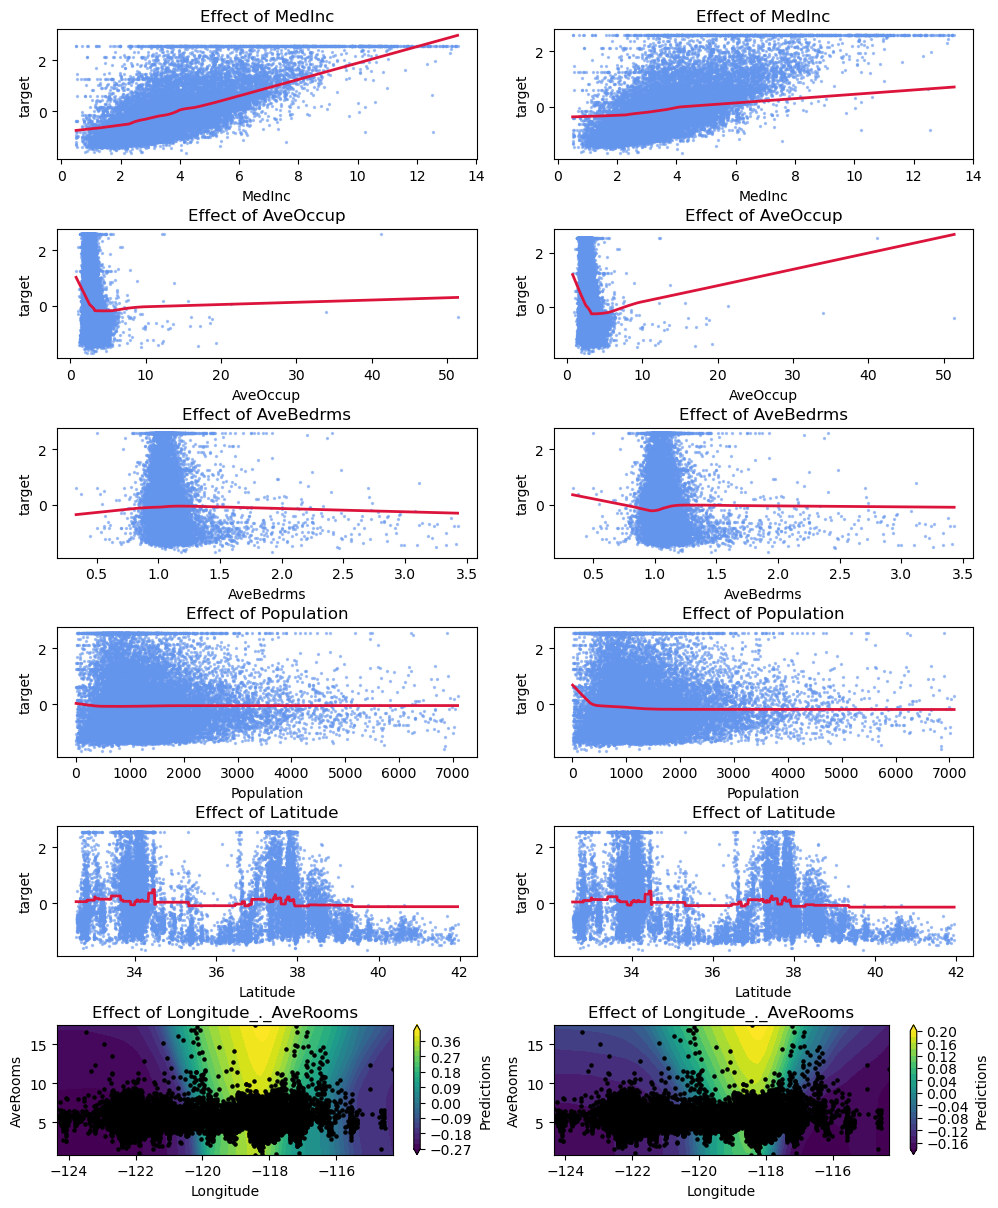

In [9]:
namlss.plot()

c:\Users\anton\anaconda3\envs\xDL_venv\lib\site-packages\keras\src\engine\functional.py:642: UserWarning:

Input dict contained keys ['MedInc', 'AveOccup', 'AveBedrms', 'Population', 'Latitude'] which did not match any model input. They will be ignored by the model.



16/16 [==============================] - 0s 6ms/step


c:\Users\anton\Desktop\Projects\xDL\examples\..\nampy\visuals\plot_distributions.py:13: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


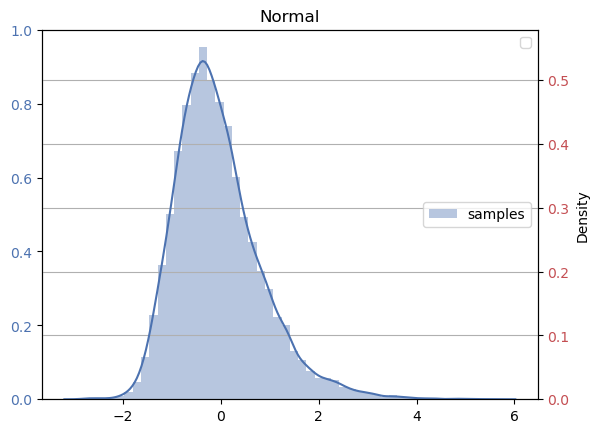

In [12]:
namlss.plot_dist()